Group Members = Hirbod Gholamniaetakhsami(hirgh815) & Sachini Bambaranda(bamba063)

# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to learn deep learning.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [19]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have? <br>**10496 CUDA cores**

Question 2: How much memory does the graphics card have?<br>**24 GB Memory**

Question 3: What is stored in the GPU memory while training a DNN ?
<br>**As we know in the training process, GPU usually handle the cumbersome task of tensor computation, as a result only certain parameters are stored in GPU memory these include: the input data, crucial model parameters(learning rate, etc) and gradients.**

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.

Remove the first 24 covariates to make the task harder.

In [20]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')

# Remove the first 24 covariates (columns)
X = X[:, 24:]

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
u_class = np.unique(Y).astype(int)
no_ex = np.bincount(Y.astype(int))
print(f'Example for class {u_class[0]} is {no_ex[0]} and class {u_class[1]} is {no_ex[1]}')


The covariates have size (764137, 92).
The labels have size (764137,).
Example for class 0 is 121621 and class 1 is 642516


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.
<br>**The naive classifier will always predicts the most frequent class. If we check our data we can see class 1 is most frequesnt. Therefore naive classifier will always pedict class 1. Accuracy of the naive classifier is the proportion of the most frequent class. In our example accuracy will be 84.1%**

In all classification tasks you should always ask these questions

- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


In [21]:
import numpy as np
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()
nans_X = np.count_nonzero(np.isnan(X))
nans_Y = np.count_nonzero(np.isnan(Y))

# Print the number of NaNs (not a number) in the labels
print(f'NaNs in Labels are {nans_X}')

# Print the number of NaNs in the covariates
print(f'NaNs in covariates are {nans_Y}')

NaNs in Labels are 0
NaNs in covariates are 0


# Part 6: Preprocessing

Lets do some simple preprocessing

In [22]:
# Convert covariates to floats
X = X.astype(float)

# Convert labels to integers
Y = Y.astype(int)

# Remove mean of each covariate (column)
mean = np.mean(X, axis=0)
X = X - mean

# Divide each covariate (column) by its standard deviation
std = np.std(X, axis=0)
X = X/std

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print(f'Mean : {np.mean(X, axis=0)}')
print(f'Standard Deviation : {np.std(X, axis=0)}')
      

Mean : [-3.19451533e-18 -6.32970181e-14  1.19926356e-13  4.56743018e-15
  4.10210037e-14  1.46130975e-13  5.85246484e-16 -1.69734859e-14
 -3.36915700e-13  1.28688437e-12 -2.69360995e-12 -1.10733213e-13
 -1.22392702e-13 -1.70649630e-13 -1.02461166e-14  2.50701280e-12
  1.47553162e-12  1.08446837e-12 -1.04981959e-13  6.83458762e-14
 -1.03373555e-13  5.98825773e-14 -1.02025960e-12 -1.68983055e-12
 -1.79101143e-12 -1.31828514e-13  4.42580403e-13  6.14635580e-13
  5.78048199e-14 -4.92623328e-13 -2.54513072e-12  1.86544900e-13
 -1.53444593e-13  1.68079591e-12  9.30041709e-13  1.50738177e-13
 -1.15688852e-12 -3.62610361e-13 -1.71390937e-12 -2.09264067e-13
  1.07161976e-12 -1.45236885e-12 -1.69724579e-14 -1.64918984e-16
 -5.13444996e-14 -1.02171349e-14 -1.74685907e-15  1.34264921e-13
  5.98801969e-14  1.48745574e-17 -4.25442340e-13  5.78079594e-14
  1.25638129e-15  1.69449684e-13  1.50725881e-13  2.14439542e-14
  3.65457183e-14  1.17260451e-13 -8.82752870e-13 -6.34816648e-13
 -1.62109649e-12  

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [23]:
from sklearn.model_selection import train_test_split

# Your code to split the dataset
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, train_size=0.7)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
count_YTrain = np.bincount(Ytrain.astype(int))
count_YTemp = np.bincount(Ytemp.astype(int))

print(f'Number of examples of each class in YTrain is {count_YTrain}')
print(f'Number of examples of each class in YTemp is {count_YTemp}')

Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).
Number of examples of each class in YTrain is [ 85249 449646]
Number of examples of each class in YTemp is [ 36372 192870]


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [24]:
from sklearn.model_selection import train_test_split

# Your code
Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, train_size=0.5)

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Make sure that the last layer always has a sigmoid activation function (why?).
<br> **In our binary classification model goal is to predict 0 or 1. When sigmoid is used as the activation function in the last layer, the outpt will be a value in between 0 and 1 which is the probability of the most frequent class. We can now set a threshold and make the binary prediction easily.**


In [25]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.losses import BinaryCrossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum = 0.9)
    elif optimizer == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(units = n_nodes, activation=act_fun, input_shape=input_shape))
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(units = n_nodes, activation=act_fun))
        if use_bn:
            model.add(BatchNormalization())
        if use_custom_dropout:
            model.add(myDropout(0.5))
        elif use_dropout:
            model.add(Dropout(0.5))
           
    
    
    # Add final layer
    model.add(Dense(units = 1, activation='sigmoid'))
    
    # Compile model
    model.compile(optimizer = optimizer, loss = BinaryCrossentropy(),  metrics=['accuracy'])
    
    return model

In [26]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


Make sure that you are using learning rate 0.1 !

### 2 layers, 20 nodes

In [12]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = Xtrain.shape[1:]

# Build the model
model1 = build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1,
              use_bn=False, use_dropout=False, use_custom_dropout=False)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval))

Epoch 1/20
54/54 [==============================] - 2s 17ms/step - loss: 0.3656 - accuracy: 0.8281 - val_loss: 0.1932 - val_accuracy: 0.8978
Epoch 2/20
54/54 [==============================] - 1s 12ms/step - loss: 0.1826 - accuracy: 0.9034 - val_loss: 0.1745 - val_accuracy: 0.9065
Epoch 3/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1724 - accuracy: 0.9081 - val_loss: 0.1683 - val_accuracy: 0.9095
Epoch 4/20
54/54 [==============================] - 1s 13ms/step - loss: 0.1676 - accuracy: 0.9103 - val_loss: 0.1647 - val_accuracy: 0.9104
Epoch 5/20
54/54 [==============================] - 1s 10ms/step - loss: 0.1647 - accuracy: 0.9114 - val_loss: 0.1624 - val_accuracy: 0.9114
Epoch 6/20
54/54 [==============================] - 1s 12ms/step - loss: 0.1627 - accuracy: 0.9143 - val_loss: 0.1606 - val_accuracy: 0.9157
Epoch 7/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1611 - accuracy: 0.9170 - val_loss: 0.1593 - val_accuracy: 0.9168
Epoch 8/20
54

In [13]:
# Evaluate the model on the test data
score =  model1.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 5s 1ms/step - loss: 0.1502 - accuracy: 0.9177
Test loss: 0.1502
Test accuracy: 0.9177


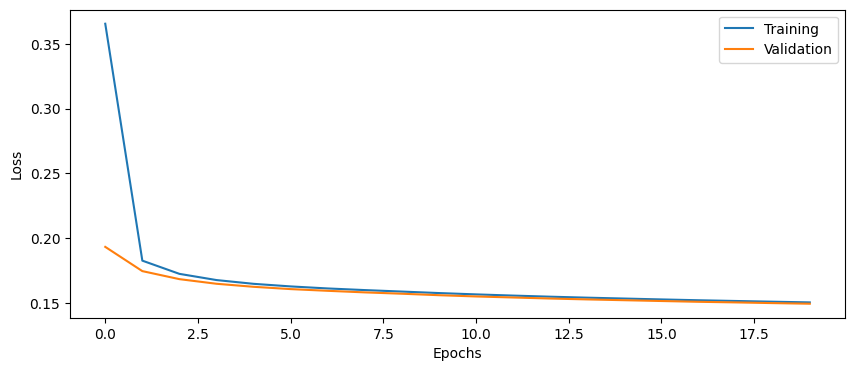

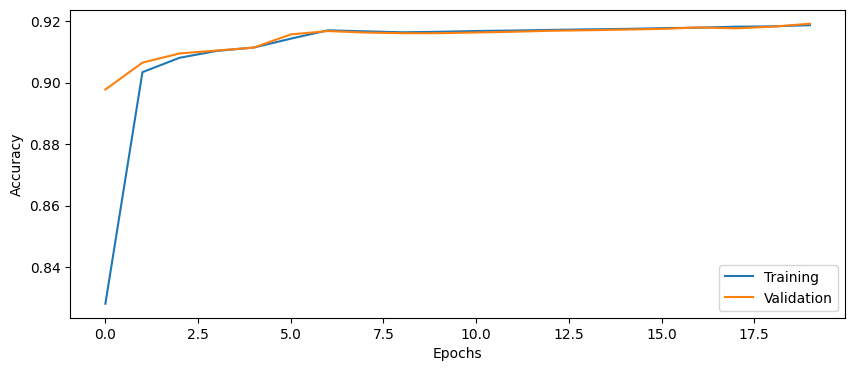

In [14]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?
<br>**If we don't specify the activation function, the default activation function will be used, in which case is linear activation function. The linear activation function is a simple calculation that sums the weighted input value from all the nodes in the previous layer and outputs it, the general form of the linear activation function is:**
<br>**y = b + w1x1 + w2x2 + ... + wnxn**

Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?
<br>**By default Keras uses GlorotUniform as the weight initializer and Zeros as the bias initializer. The GlorotUniform initializer draws samples from a uniform distribution within [-limit, limit], where :**


limit= sqrt(6 / (fan_in + fan_out))

**fan_in is the number of input units in the weight tensor and fan_out is the number of output units in the weight tensor. The Zeros initializer on the other hand, just returns a tensor(a high-dimensional array) of zeros.**

# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [8]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = u_class, y = Y)

# Print the class weights
print(class_weights)

# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights, 
# or get them from the array that is returned from class_weight

class_weights = {0: class_weights[0],
                 1: class_weights[1]}


[3.14146817 0.59464434]


### 2 layers, 20 nodes, class weights

In [16]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1:]

# Build and train model
model2 = build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1)

history2 = model2.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval),class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 13ms/step - loss: 0.4143 - accuracy: 0.8200 - val_loss: 0.2619 - val_accuracy: 0.8836
Epoch 2/20
54/54 [==============================] - 1s 9ms/step - loss: 0.2018 - accuracy: 0.8920 - val_loss: 0.2450 - val_accuracy: 0.8976
Epoch 3/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1898 - accuracy: 0.8996 - val_loss: 0.2331 - val_accuracy: 0.9017
Epoch 4/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1835 - accuracy: 0.9043 - val_loss: 0.2283 - val_accuracy: 0.9078
Epoch 5/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1793 - accuracy: 0.9087 - val_loss: 0.2215 - val_accuracy: 0.9102
Epoch 6/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1761 - accuracy: 0.9103 - val_loss: 0.2210 - val_accuracy: 0.9110
Epoch 7/20
54/54 [==============================] - 1s 10ms/step - loss: 0.1736 - accuracy: 0.9111 - val_loss: 0.2222 - val_accuracy: 0.9116
Epoch 8/20
54/54 

In [17]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 5s 1ms/step - loss: 0.2114 - accuracy: 0.9161
Test loss: 0.2114
Test accuracy: 0.9161


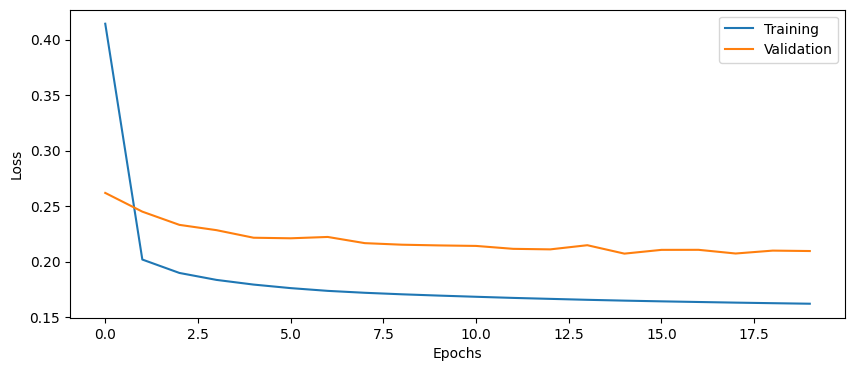

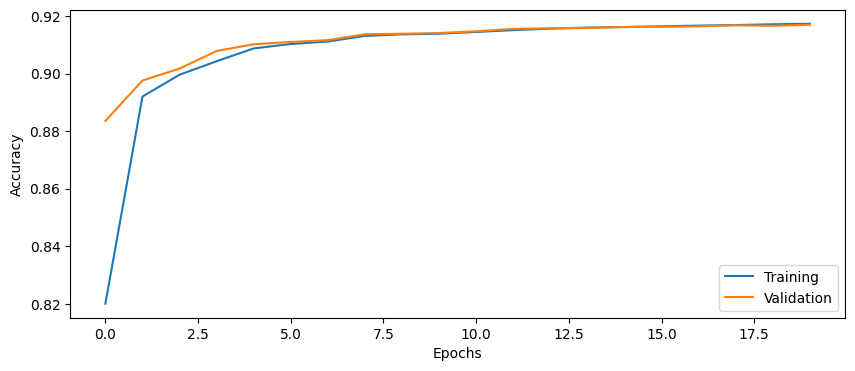

In [18]:
plot_results(history2)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.
<br>**Batch size is number of samples that are considered in each training session. When training large datasets small batches of data is beneficial since memory required to store these data is less and the model can update parameters in each iteration which will converge faster and also improve performance. In regards to the effect of batch size parameter, it was shown that that increasing batch size lowers performance and there is an interesting relationship between batch size of the model and learning rate(Parameters such as decay can be effective as well).**
<br>**correction- first part: Indeed, what you described in the case of training in GPU holds true and in fact using batch size can improve the training effectiveness by adding noise to the process. I Guess the best answer to this questions is that "it depends". Other than previous mentioned information, using small batches would make the network to take more steps to converge and this might slow downn the convergence**
<br>**correction- second part: In the last part of our answers we meant to mention relationship between training batches and learning rate and in general terms this relationship is not so straightforward and is dependant on other factors as well. You can find more information about this in the following article:
Smith, Samuel L., et al. "Don't decay the learning rate, increase the batch size." arXiv preprint arXiv:1711.00489 (2017).**

Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  
**Since the weights are updated after each batch, and we know the training set has 534895 samples, the weights are updated N/batch_size times. For example, if the batch size is 100, the weights are updated 534895/100 = 5348.95 ~= 5349 times. and if the batch size is 1000, the weights are updated 534895/1000 = 534.895 ~= 535 times. for the last case, if the batch size is 10000, the weights are updated 534895/10000 = 53.4895 ~= 54 times.**


Question 11: What limits how large the batch size can be?
<br>**The amount of available memory on the GPU or CPU**

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?
<br>**The learning rate should be decreased if the batch size is decreased. This is because the learning rate is basically the "step size" of the gradient descent algorithm, and if the batch size is decreased, the gradient descent algorithm will take more steps to reach the minimum of the loss function. There is also the decay factor that can be used to decrease the learning rate(therefore applying a dynamic learning rate), but in Literature, changing the learning rate and Batch size ar more common to reach the performance peak of the model.**
<br>** correction: If the batch size is too small, the model will not be able to generalize well and will overfit the training data. In this case, the learning rate should be decreased.**

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

### 4 layers, 20 nodes, class weights

In [19]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1:]

# Build and train model
model3 = build_DNN(input_shape, n_layers=4, n_nodes=20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1)

history3 = model3.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.4952 - val_loss: 0.6878 - val_accuracy: 0.8767
Epoch 2/20
54/54 [==============================] - 1s 15ms/step - loss: 0.6781 - accuracy: 0.8066 - val_loss: 0.6465 - val_accuracy: 0.8760
Epoch 3/20
54/54 [==============================] - 1s 13ms/step - loss: 0.4054 - accuracy: 0.8781 - val_loss: 0.2603 - val_accuracy: 0.8807
Epoch 4/20
54/54 [==============================] - 1s 16ms/step - loss: 0.2012 - accuracy: 0.8912 - val_loss: 0.2438 - val_accuracy: 0.8976
Epoch 5/20
54/54 [==============================] - 1s 10ms/step - loss: 0.1882 - accuracy: 0.9007 - val_loss: 0.2314 - val_accuracy: 0.9050
Epoch 6/20
54/54 [==============================] - 1s 10ms/step - loss: 0.1805 - accuracy: 0.9075 - val_loss: 0.2272 - val_accuracy: 0.9097
Epoch 7/20
54/54 [==============================] - 1s 10ms/step - loss: 0.1760 - accuracy: 0.9105 - val_loss: 0.2205 - val_accuracy: 0.9116
Epoch 8/20
54

In [20]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 5s 1ms/step - loss: 0.2127 - accuracy: 0.9163
Test loss: 0.2127
Test accuracy: 0.9163


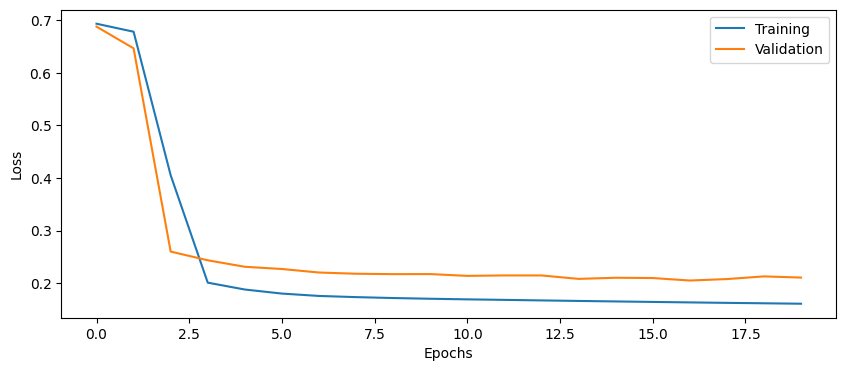

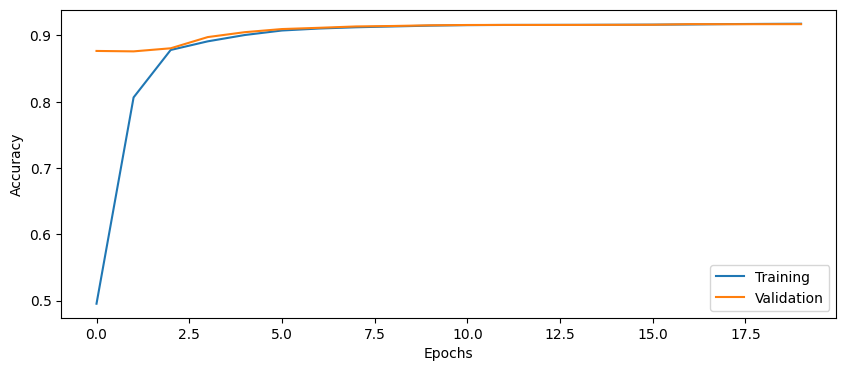

In [21]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [22]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1:]

# Build and train model
model4 = build_DNN(input_shape, n_layers=2, n_nodes=50, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1)

history4 = model4.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights) 

Epoch 1/20
54/54 [==============================] - 4s 52ms/step - loss: 0.3386 - accuracy: 0.8701 - val_loss: 0.2552 - val_accuracy: 0.8919
Epoch 2/20
54/54 [==============================] - 1s 21ms/step - loss: 0.1939 - accuracy: 0.8962 - val_loss: 0.2347 - val_accuracy: 0.8980
Epoch 3/20
54/54 [==============================] - 1s 20ms/step - loss: 0.1842 - accuracy: 0.9011 - val_loss: 0.2300 - val_accuracy: 0.9043
Epoch 4/20
54/54 [==============================] - 1s 17ms/step - loss: 0.1789 - accuracy: 0.9074 - val_loss: 0.2227 - val_accuracy: 0.9098
Epoch 5/20
54/54 [==============================] - 1s 21ms/step - loss: 0.1756 - accuracy: 0.9103 - val_loss: 0.2193 - val_accuracy: 0.9112
Epoch 6/20
54/54 [==============================] - 1s 21ms/step - loss: 0.1733 - accuracy: 0.9111 - val_loss: 0.2210 - val_accuracy: 0.9115
Epoch 7/20
54/54 [==============================] - 1s 20ms/step - loss: 0.1715 - accuracy: 0.9116 - val_loss: 0.2206 - val_accuracy: 0.9117
Epoch 8/20
54

In [23]:
# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 5s 1ms/step - loss: 0.2130 - accuracy: 0.9157
Test loss: 0.2130
Test accuracy: 0.9157


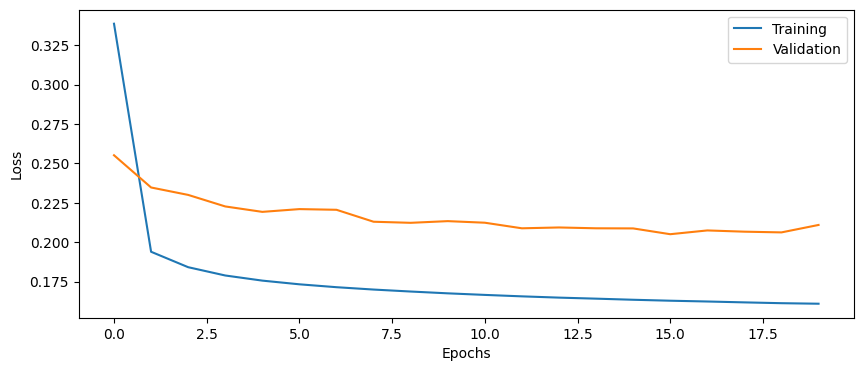

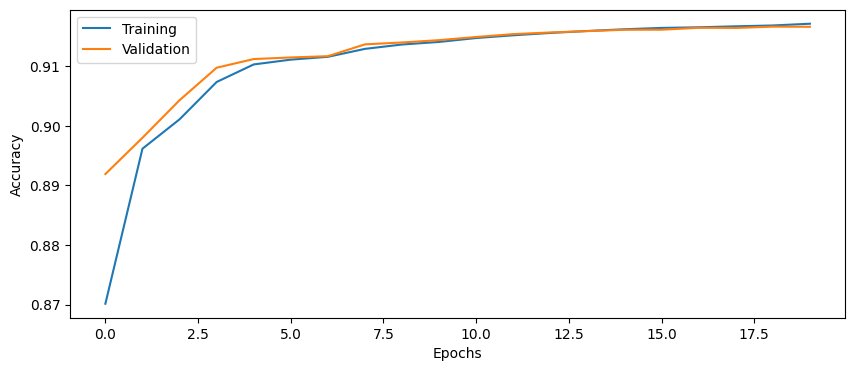

In [24]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [25]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1:]

# Build and train model
model5 = build_DNN(input_shape, n_layers=4, n_nodes=50, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1)

history5 = model5.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 5s 40ms/step - loss: 0.7151 - accuracy: 0.5063 - val_loss: 0.7169 - val_accuracy: 0.1570
Epoch 2/20
54/54 [==============================] - 2s 28ms/step - loss: 0.6716 - accuracy: 0.7601 - val_loss: 0.6342 - val_accuracy: 0.8758
Epoch 3/20
54/54 [==============================] - 1s 26ms/step - loss: 0.3325 - accuracy: 0.8822 - val_loss: 0.2503 - val_accuracy: 0.8900
Epoch 4/20
54/54 [==============================] - 1s 27ms/step - loss: 0.1953 - accuracy: 0.8958 - val_loss: 0.2339 - val_accuracy: 0.8992
Epoch 5/20
54/54 [==============================] - 2s 28ms/step - loss: 0.1848 - accuracy: 0.9014 - val_loss: 0.2315 - val_accuracy: 0.9048
Epoch 6/20
54/54 [==============================] - 1s 27ms/step - loss: 0.1787 - accuracy: 0.9081 - val_loss: 0.2255 - val_accuracy: 0.9101
Epoch 7/20
54/54 [==============================] - 2s 28ms/step - loss: 0.1747 - accuracy: 0.9108 - val_loss: 0.2193 - val_accuracy: 0.9114
Epoch 8/20
54

In [26]:
# Evaluate model on test data
score = model5.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 5s 1ms/step - loss: 0.2110 - accuracy: 0.9162
Test loss: 0.2110
Test accuracy: 0.9162


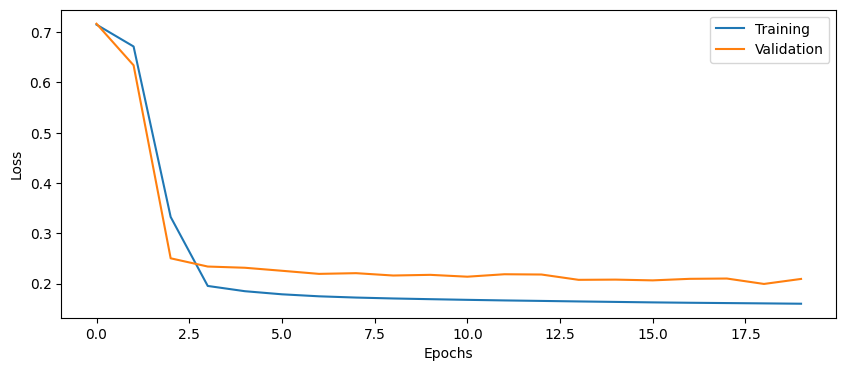

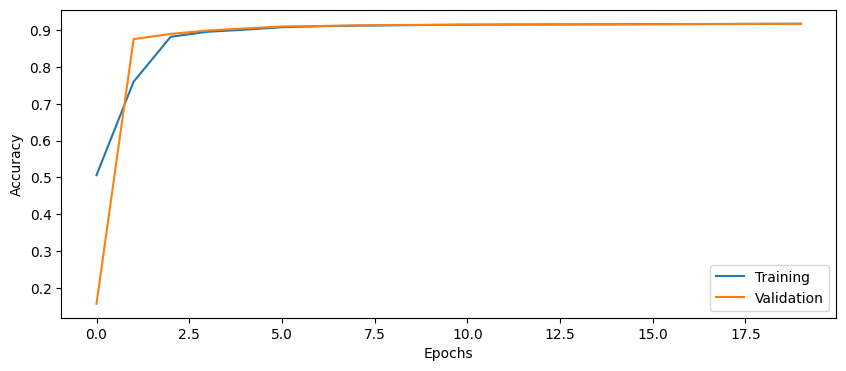

In [27]:
plot_results(history5)

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?
<br>**Batch normalization address the problem of internal covariate shif, where the distribution of inputs to a layer of a neural network changes as the network parameters are updated during training. This will slow down the convergence.Batch normalization technique normalizes the contributions to a layer for every mini-batch solving the problem.**

### 2 layers, 20 nodes, class weights, batch normalization

In [28]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1:]

# Build and train model
model6 = build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_bn=True )

history6 = model6.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 6s 56ms/step - loss: 0.2328 - accuracy: 0.8898 - val_loss: 0.5602 - val_accuracy: 0.8430
Epoch 2/20
54/54 [==============================] - 1s 21ms/step - loss: 0.1735 - accuracy: 0.9131 - val_loss: 0.5848 - val_accuracy: 0.8430
Epoch 3/20
54/54 [==============================] - 1s 23ms/step - loss: 0.1686 - accuracy: 0.9151 - val_loss: 0.5615 - val_accuracy: 0.8430
Epoch 4/20
54/54 [==============================] - 1s 16ms/step - loss: 0.1653 - accuracy: 0.9160 - val_loss: 0.5004 - val_accuracy: 0.8430
Epoch 5/20
54/54 [==============================] - 1s 13ms/step - loss: 0.1632 - accuracy: 0.9164 - val_loss: 0.4347 - val_accuracy: 0.8430
Epoch 6/20
54/54 [==============================] - 1s 20ms/step - loss: 0.1627 - accuracy: 0.9168 - val_loss: 0.3440 - val_accuracy: 0.8434
Epoch 7/20
54/54 [==============================] - 1s 16ms/step - loss: 0.1604 - accuracy: 0.9174 - val_loss: 0.2642 - val_accuracy: 0.8523
Epoch 8/20
54

In [29]:
# Evaluate model on test data
score = model6.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 6s 2ms/step - loss: 0.1430 - accuracy: 0.9291
Test loss: 0.1430
Test accuracy: 0.9291


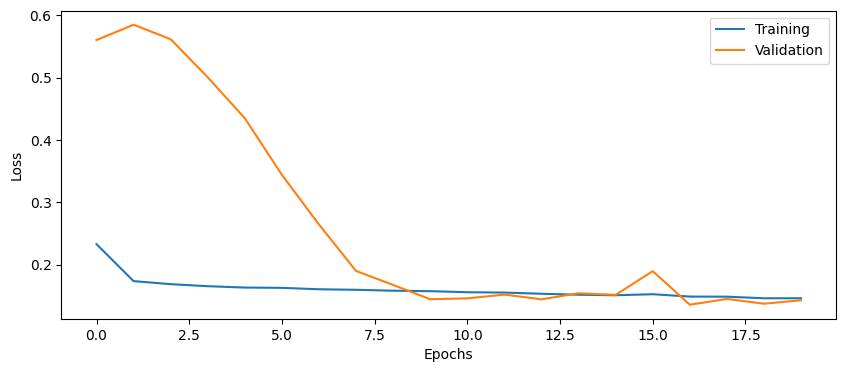

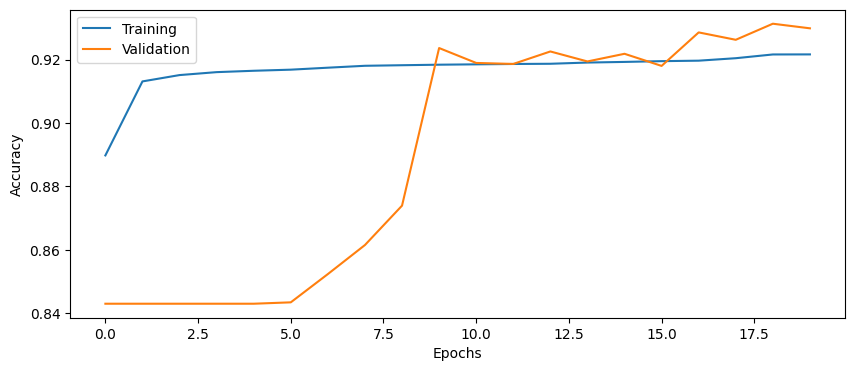

In [30]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [32]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1:]

# Build and train model
model7 = build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun='ReLU', optimizer='sgd', learning_rate=0.1)


history7 = model7.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 20ms/step - loss: 0.2196 - accuracy: 0.8973 - val_loss: 0.2142 - val_accuracy: 0.9126
Epoch 2/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1680 - accuracy: 0.9134 - val_loss: 0.2085 - val_accuracy: 0.9172
Epoch 3/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1631 - accuracy: 0.9162 - val_loss: 0.2011 - val_accuracy: 0.9182
Epoch 4/20
54/54 [==============================] - 1s 12ms/step - loss: 0.1607 - accuracy: 0.9171 - val_loss: 0.1991 - val_accuracy: 0.9189
Epoch 5/20
54/54 [==============================] - 1s 11ms/step - loss: 0.1588 - accuracy: 0.9178 - val_loss: 0.1942 - val_accuracy: 0.9195
Epoch 6/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1573 - accuracy: 0.9182 - val_loss: 0.1966 - val_accuracy: 0.9196
Epoch 7/20
54/54 [==============================] - 0s 9ms/step - loss: 0.1565 - accuracy: 0.9183 - val_loss: 0.2041 - val_accuracy: 0.9194
Epoch 8/20
54/54

In [33]:
# Evaluate model on test data
score = model7.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.1717
Test accuracy: 0.9218


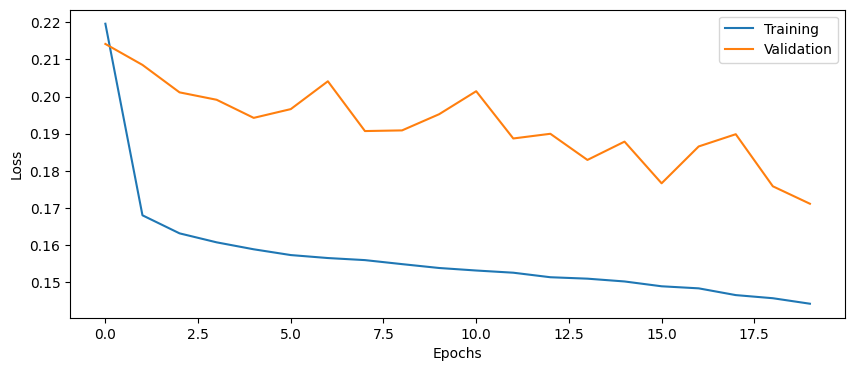

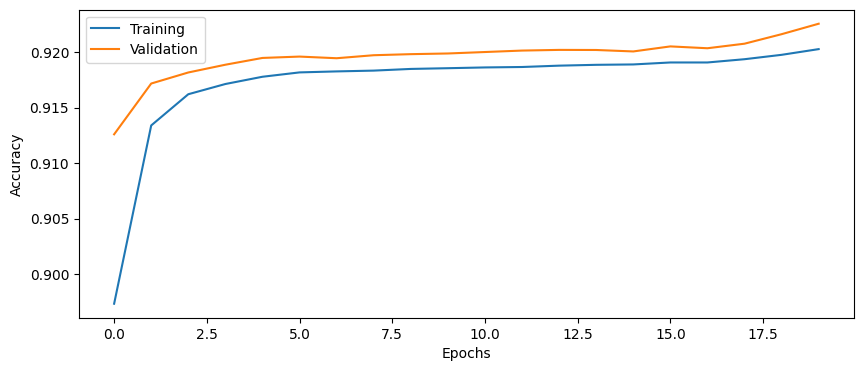

In [34]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [28]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1:]

# Build and train model
model8 = build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='Adam', learning_rate=0.1)

history8 = model7.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 14ms/step - loss: nan - accuracy: 0.1594 - val_loss: nan - val_accuracy: 0.1599
Epoch 2/20
54/54 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.1594 - val_loss: nan - val_accuracy: 0.1599
Epoch 3/20
54/54 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.1594 - val_loss: nan - val_accuracy: 0.1599
Epoch 4/20
54/54 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.1594 - val_loss: nan - val_accuracy: 0.1599
Epoch 5/20
54/54 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.1594 - val_loss: nan - val_accuracy: 0.1599
Epoch 6/20
54/54 [==============================] - 1s 12ms/step - loss: nan - accuracy: 0.1594 - val_loss: nan - val_accuracy: 0.1599
Epoch 7/20
54/54 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.1594 - val_loss: nan - val_accuracy: 0.1599
Epoch 8/20
54/54 [==============================] - 1s 10m

In [35]:
# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 6s 2ms/step - loss: 0.4402 - accuracy: 0.8425
Test loss: 0.4402
Test accuracy: 0.8425


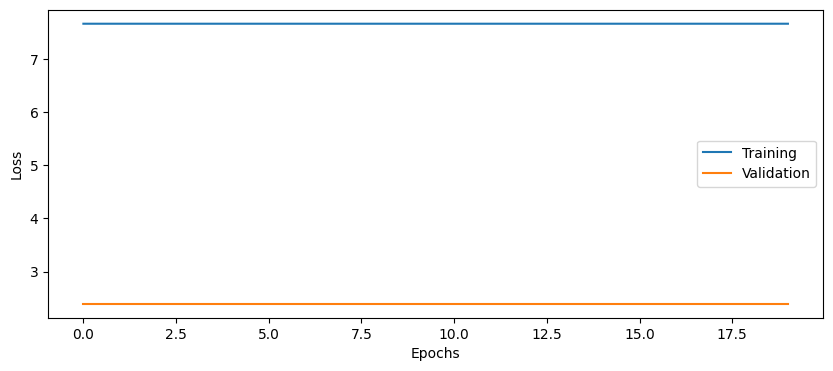

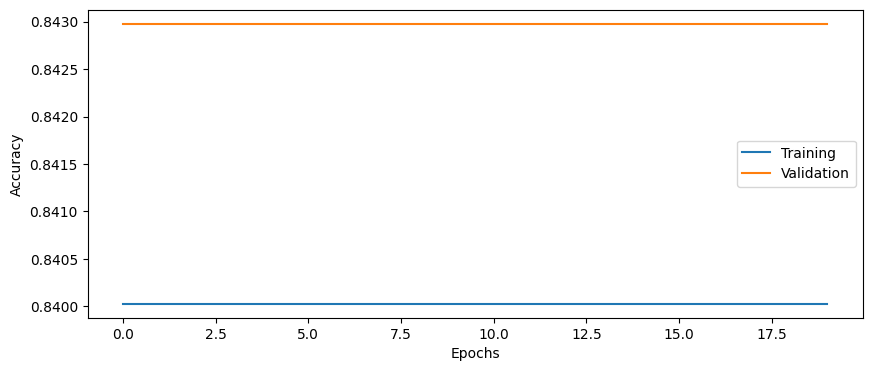

In [36]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?

Question 16: How does the test accuracy change when adding dropout?
<br>**In this model validation accuracy and test accuracy is reduced when dropout is added. Drpout is generally used to reduce the risk of overfitting in deep networks. Since we have only 2 layers using 0.5 fraction dropout may be lead to poor performance Both the validation and test accuracy values are lower than the model 2. The validation accuracy in model 9 is 0.9169 and the test accuracy is 0.9167. The model 2 has a validation accuracy of 0.9186(or 0.9187) and a test accuracy of 0.9187. The model 2 is better than the model below, but the difference is not that big.**

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [37]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1:]

# Build and train model
model9 = build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_dropout=True)

history9 = model9.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 16ms/step - loss: 0.4760 - accuracy: 0.7631 - val_loss: 0.2668 - val_accuracy: 0.8799
Epoch 2/20
54/54 [==============================] - 1s 12ms/step - loss: 0.2463 - accuracy: 0.8787 - val_loss: 0.2457 - val_accuracy: 0.8835
Epoch 3/20
54/54 [==============================] - 1s 11ms/step - loss: 0.2223 - accuracy: 0.8857 - val_loss: 0.2366 - val_accuracy: 0.8958
Epoch 4/20
54/54 [==============================] - 1s 11ms/step - loss: 0.2085 - accuracy: 0.8932 - val_loss: 0.2302 - val_accuracy: 0.8992
Epoch 5/20
54/54 [==============================] - 1s 16ms/step - loss: 0.2001 - accuracy: 0.8973 - val_loss: 0.2265 - val_accuracy: 0.9022
Epoch 6/20
54/54 [==============================] - 1s 20ms/step - loss: 0.1941 - accuracy: 0.9005 - val_loss: 0.2227 - val_accuracy: 0.9055
Epoch 7/20
54/54 [==============================] - 1s 14ms/step - loss: 0.1900 - accuracy: 0.9034 - val_loss: 0.2220 - val_accuracy: 0.9076
Epoch 8/20
54

In [38]:
# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 8s 2ms/step - loss: 0.2169 - accuracy: 0.9148
Test loss: 0.2169
Test accuracy: 0.9148


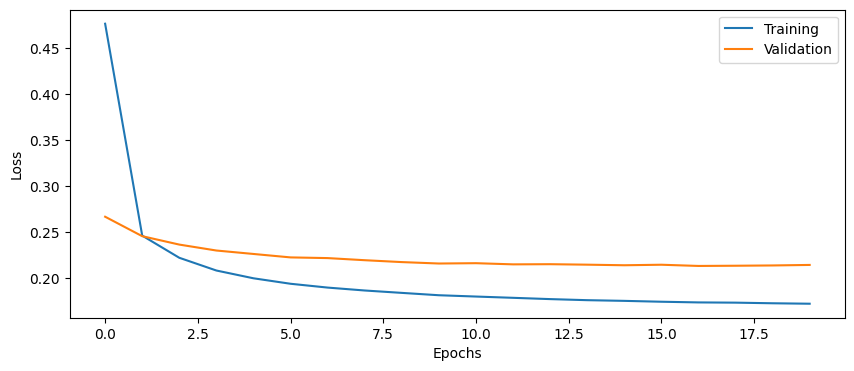

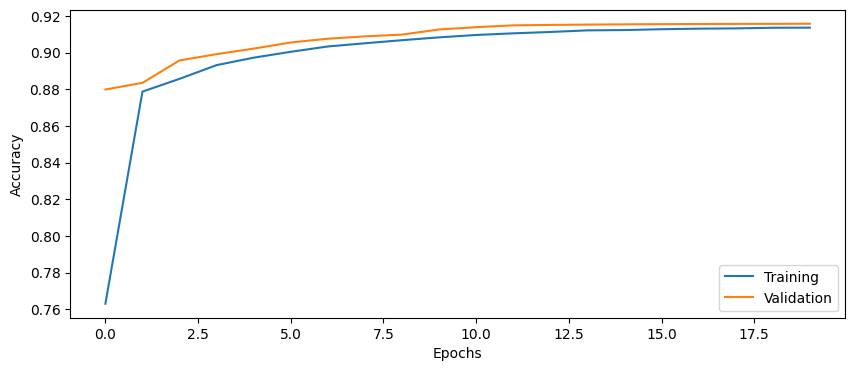

In [39]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?
<br>**The best configuration is 5 layers, 50 nodes, sgd optimizer, sigmoid activation function, using batch normalization, learning rate 0.1, balanced weights, batch size 1000 and epochs 20**

In [40]:
# Find your best configuration for the DNN
batch_size = 1000
epochs = 20
input_shape = Xtrain.shape[1:]

# Build and train DNN
model10 = build_DNN(input_shape, n_layers=5, n_nodes=50, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_dropout=False, use_bn=True,)

history10 = model10.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)


Epoch 1/20
535/535 [==============================] - 7s 9ms/step - loss: 0.1735 - accuracy: 0.9146 - val_loss: 0.2287 - val_accuracy: 0.9166
Epoch 2/20
535/535 [==============================] - 6s 11ms/step - loss: 0.1587 - accuracy: 0.9182 - val_loss: 0.2516 - val_accuracy: 0.9166
Epoch 3/20
535/535 [==============================] - 4s 7ms/step - loss: 0.1512 - accuracy: 0.9223 - val_loss: 0.2277 - val_accuracy: 0.9199
Epoch 4/20
535/535 [==============================] - 4s 7ms/step - loss: 0.1420 - accuracy: 0.9279 - val_loss: 0.2177 - val_accuracy: 0.9280
Epoch 5/20
535/535 [==============================] - 4s 7ms/step - loss: 0.1357 - accuracy: 0.9311 - val_loss: 0.1848 - val_accuracy: 0.9263
Epoch 6/20
535/535 [==============================] - 4s 7ms/step - loss: 0.1316 - accuracy: 0.9327 - val_loss: 0.1854 - val_accuracy: 0.9310
Epoch 7/20
535/535 [==============================] - 4s 7ms/step - loss: 0.1326 - accuracy: 0.9324 - val_loss: 0.2429 - val_accuracy: 0.9217
Epoch

In [41]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 6s 2ms/step - loss: 0.2586 - accuracy: 0.9226
Test loss: 0.2586
Test accuracy: 0.9226


# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 18: What is the mean and the standard deviation of the test accuracy?

In [27]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [43]:
# Your best training parameters
batch_size = 1000
epochs = 20
input_shape = Xtrain.shape[1:]

# Build and train model
model11 = build_DNN(input_shape, n_layers=5, n_nodes=50, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_dropout=False, use_bn=True, use_custom_dropout=True)


history11 = model11.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)


Epoch 1/20
535/535 [==============================] - 9s 14ms/step - loss: 0.2065 - accuracy: 0.9040 - val_loss: 0.2408 - val_accuracy: 0.9151
Epoch 2/20
535/535 [==============================] - 6s 12ms/step - loss: 0.1792 - accuracy: 0.9155 - val_loss: 0.2108 - val_accuracy: 0.9160
Epoch 3/20
535/535 [==============================] - 6s 11ms/step - loss: 0.1757 - accuracy: 0.9156 - val_loss: 0.2306 - val_accuracy: 0.9155
Epoch 4/20
535/535 [==============================] - 7s 12ms/step - loss: 0.1727 - accuracy: 0.9166 - val_loss: 0.2429 - val_accuracy: 0.9160
Epoch 5/20
535/535 [==============================] - 6s 12ms/step - loss: 0.1704 - accuracy: 0.9169 - val_loss: 0.1990 - val_accuracy: 0.9174
Epoch 6/20
535/535 [==============================] - 7s 14ms/step - loss: 0.1699 - accuracy: 0.9170 - val_loss: 0.2305 - val_accuracy: 0.9164
Epoch 7/20
535/535 [==============================] - 7s 12ms/step - loss: 0.1695 - accuracy: 0.9171 - val_loss: 0.2178 - val_accuracy: 0.9175

In [44]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest, Ytest)
                       
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 7s 2ms/step - loss: 0.2157 - accuracy: 0.9176
Test accuracy: 0.9176


In [45]:
# Run the testing 100 times, and save the accuracies in an array
acc_100 = [model11.evaluate(Xtest, Ytest)[1] for i in range(100)]
    
# Calculate and print mean and std of accuracies
print(f'Mean Accuracy: {np.mean(acc_100):.4f}')
print(f'Std Accuracy: {np.std(acc_100):.4f}')


3582/3582 [==============================] - 9s 2ms/step - loss: 0.2153 - accuracy: 0.9175
Mean Accuracy: 0.9176
Std Accuracy: 0.0001


Text(0, 0.5, 'Frequency')

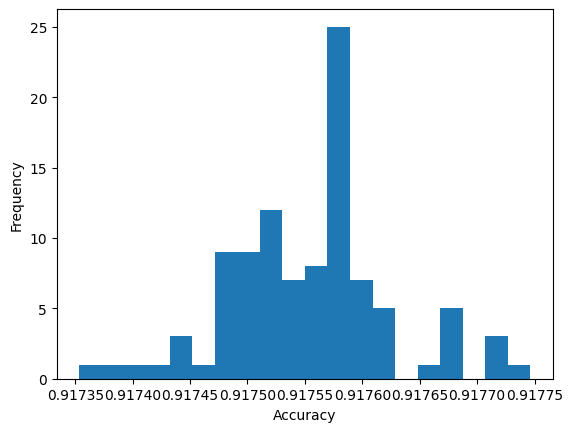

In [46]:
# Plot the distribution of accuracies
plt.hist(acc_100, bins=20)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?

Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.
<br> **Dropout randomly drop a given fraction of neurons from each layer while CV split the data into subsets and train and test the model using different combinations of these subsets. CV is computationally expensive and time consuming but dropout will average the predictions of slightly different models which is computationally effective**

In [47]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation
skf = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

#To store accuracy
accuracy =[]

# Loop over cross validation folds
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    Xtrain = X[train_index]
    Ytrain = Y[train_index]
    Xtest = X[test_index]
    Ytest = Y[test_index]
    
    # Calculate class weights for current split
    class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(Ytrain), y = Ytrain)
    class_weights = {0: class_weights[0], 1: class_weights[1]}
    
    # Rebuild the DNN model, to not continue training on the previously trained model
    batch_size = 1000
    epochs = 20
    input_shape = Xtrain.shape[1:]
    model12 = build_DNN(input_shape, n_layers=5, n_nodes=50, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, use_dropout=False, use_bn=True)
    
    # Fit the model with training set and class weights for this fold
    history12 = model12.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)
    
    # Evaluate the model using the test set for this fold
    score = model12.evaluate(Xtest, Ytest)
    
    # Save the test accuracy in an array
    accuracy.append(score[1])
    
# Calculate and print mean and std of accuracies
print(f'Mean Accuracy: {np.mean(accuracy):.4f}')
print(f'Std Accuracy: {np.std(accuracy):.4f}')


Epoch 1/20
688/688 [==============================] - 10s 10ms/step - loss: 0.1722 - accuracy: 0.9145 - val_loss: 0.2181 - val_accuracy: 0.9157
Epoch 2/20
688/688 [==============================] - 6s 9ms/step - loss: 0.1567 - accuracy: 0.9191 - val_loss: 0.2280 - val_accuracy: 0.9187
Epoch 3/20
688/688 [==============================] - 6s 8ms/step - loss: 0.1438 - accuracy: 0.9265 - val_loss: 0.1549 - val_accuracy: 0.9335
Epoch 4/20
688/688 [==============================] - 6s 8ms/step - loss: 0.1401 - accuracy: 0.9288 - val_loss: 0.2001 - val_accuracy: 0.9313
Epoch 5/20
688/688 [==============================] - 6s 8ms/step - loss: 0.1330 - accuracy: 0.9320 - val_loss: 0.1632 - val_accuracy: 0.9337
Epoch 6/20
688/688 [==============================] - 6s 8ms/step - loss: 0.1300 - accuracy: 0.9334 - val_loss: 0.2566 - val_accuracy: 0.9224
Epoch 7/20
688/688 [==============================] - 6s 9ms/step - loss: 0.1269 - accuracy: 0.9345 - val_loss: 0.1517 - val_accuracy: 0.9328
Epoc

# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN used in this lab in order to use it for regression instead?
<br>**TDesigning a DNN for regression is similar to designing a DNN for classification. The only difference is that the output layer should have only one node, and the activation function should be linear. The loss function should also be changed to mean squared error (MSE). The rest of the design is the same as for classification(Concepts are different but codes are similar).**

## Report

Send in this jupyter notebook, with answers to all questions.